In [125]:
# Import 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

import sys
sys.path.append('../')
from helpers import cm2inch, title, show_num_contours, load_datasets
from melodic_contour import *
from sklearn import metrics

import tslearn
matplotlib.style.use('styles.mplstyle')

In [126]:
from tslearn.utils import to_time_series_dataset

In [199]:
def derivative(timeseries, smooth=False):
    d1 = timeseries[:, 1:] - timeseries[:, :-1]
    zeros = np.zeros((timeseries.shape[0], 1))
    if smooth:
        d2 = (timeseries[:, 2:] - timeseries[:, :-2]) / 2
        avg = (d1[:, 1:] + d2) / 2
        return np.concatenate((zeros, avg, zeros), axis=1) 
    else:
        return np.append(d1, zeros, axis=1) 
    
def integrate(derivatives):
    return np.append(
        np.zeros((derivatives.shape[0], 1)), 
        np.cumsum(derivatives, axis=1)[:, :-1], 
        axis=1)

In [128]:
dfs, contours = load_datasets(normalize=False)

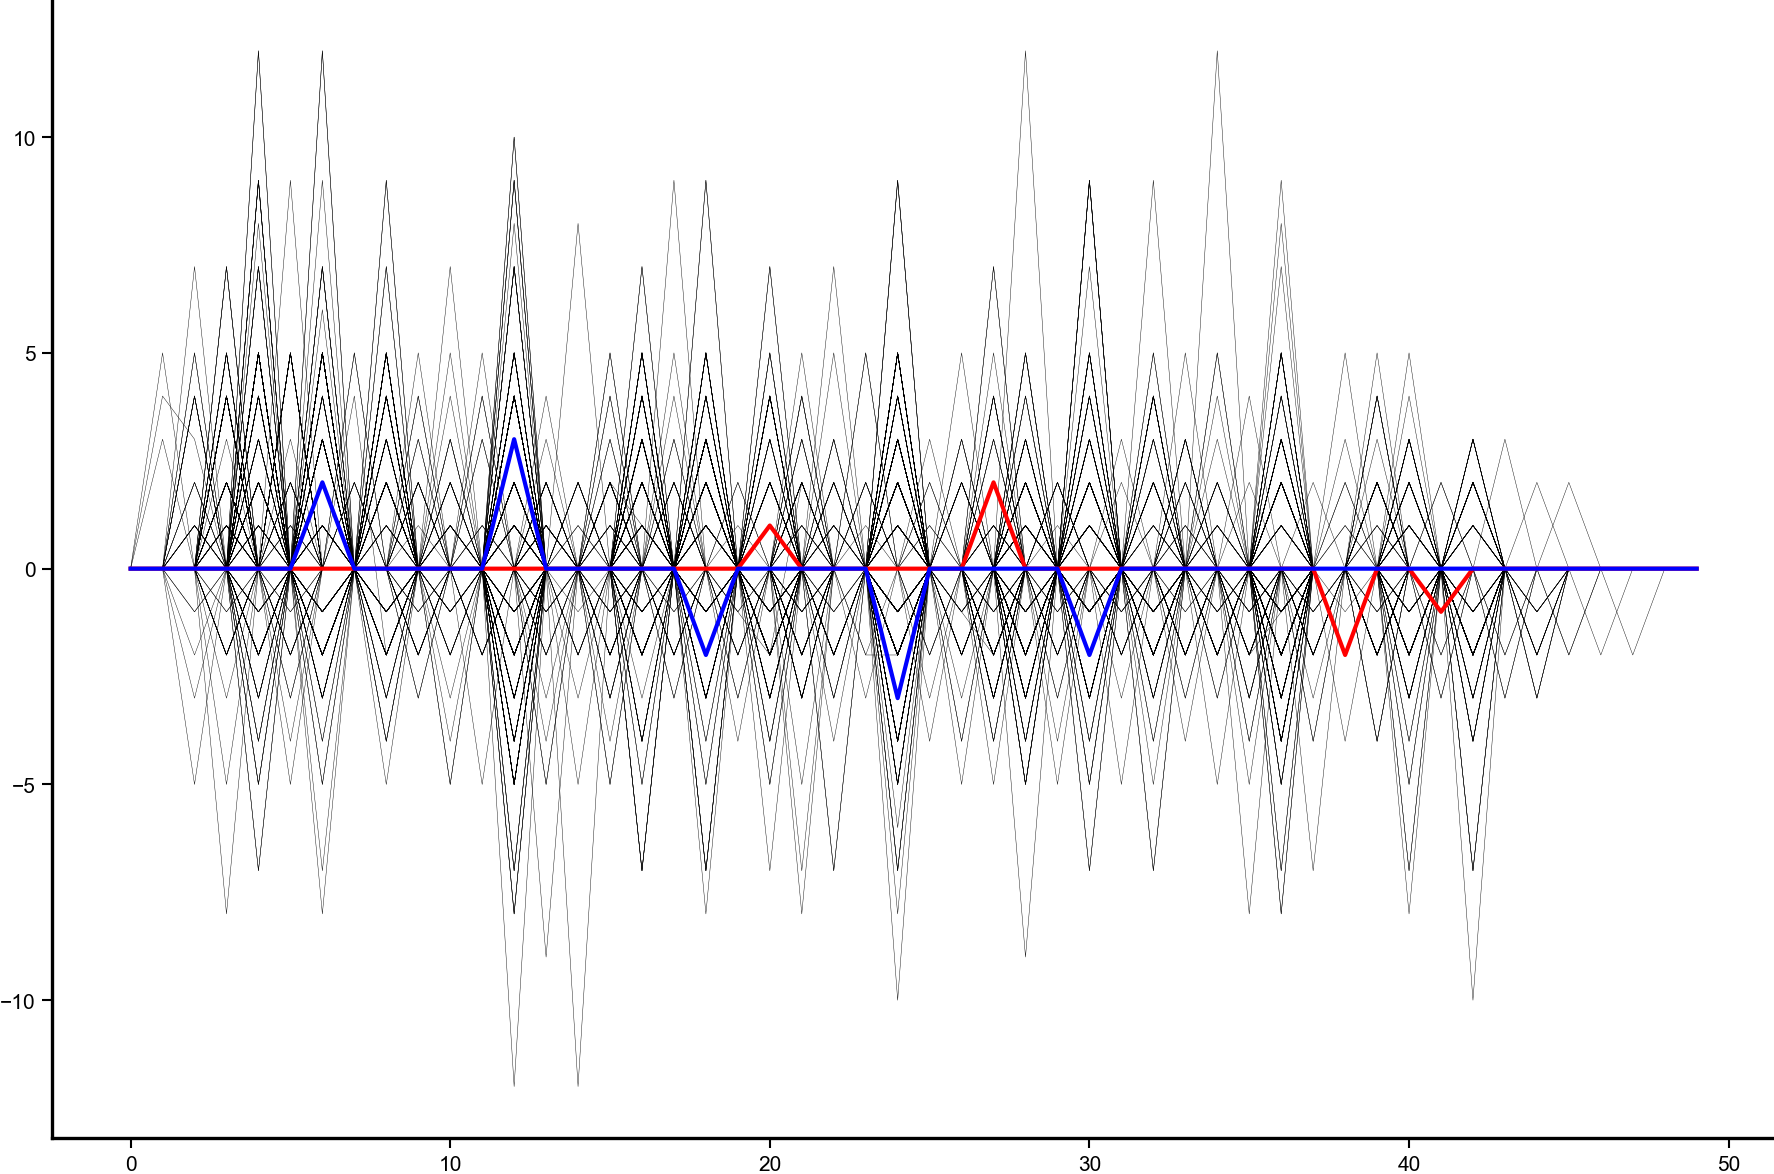

In [198]:
intervals = derivative(contours['erk'][:500, :], smooth=False)
plt.plot(intervals.T, 'k-', lw=.1);
plt.plot(intervals[0, :].T, 'r-', lw=1);
plt.plot(intervals[1, :].T, 'b-', lw=1);

In [200]:
dataset = to_time_series_dataset(intervals)
dataset.shape

(500, 50, 1)

## k-means using DTW

In [202]:
km = TimeSeriesKMeans(n_clusters=4, metric="dtw")
km.fit(dataset)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=50,
                 max_iter_barycenter=100, metric='dtw', metric_params=None,
                 n_clusters=4, n_init=1, n_jobs=None, random_state=None,
                 tol=1e-06, verbose=0)

In [203]:
y_pred = km.predict(dataset)

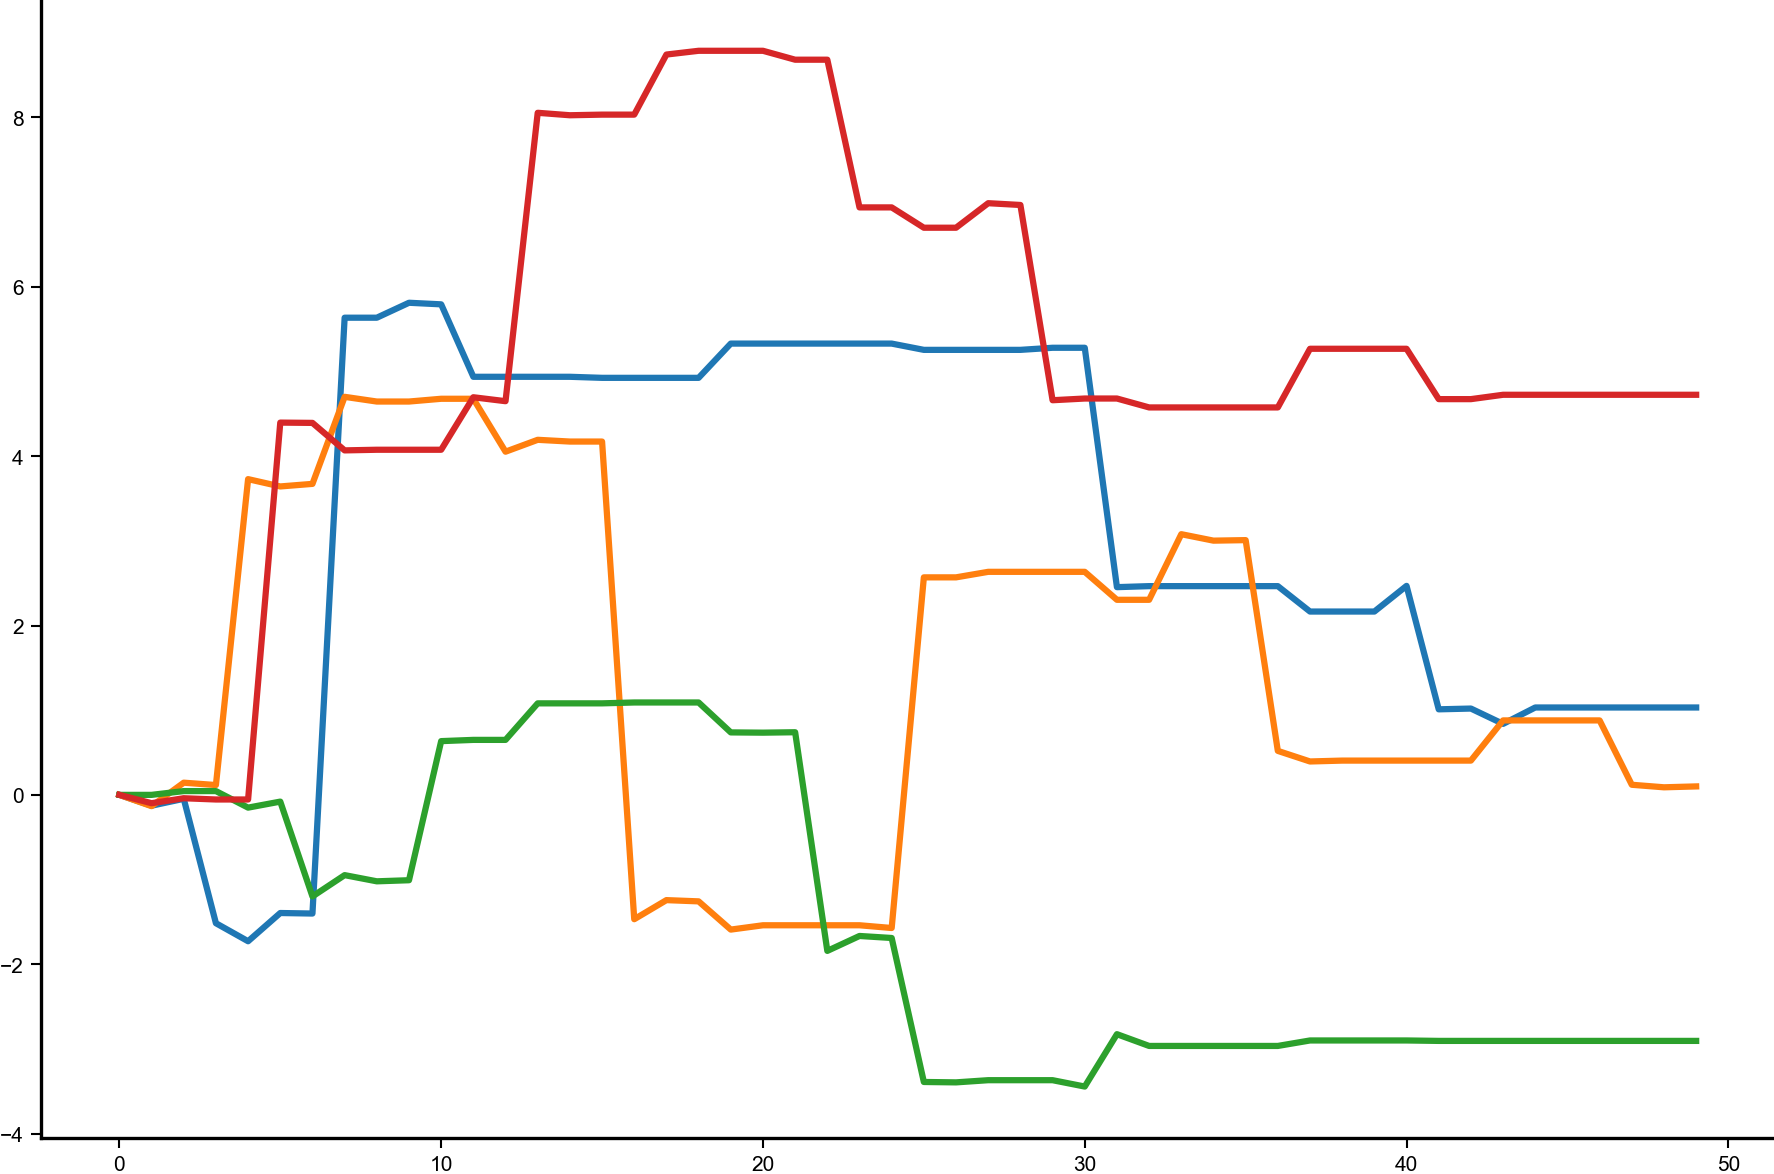

In [375]:
plt.plot(integrate(km.cluster_centers_[:,:,0]).T)

In [308]:
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.barycenters import softdtw_barycenter
from tslearn.barycenters import euclidean_barycenter

In [348]:
def show_contours(contours, normalize=False, bary_eucl=True, bary_dtw=False, highlight=3):
    linestyles = ["-", "--", ":", "-."]
    if normalize:
        contours = contours - contours.mean(axis=1)[:, np.newaxis]
    plt.plot(contours.T, 'k', lw=.1, alpha=.2);
    for i in range(highlight):
        plt.plot(contours[[i], :].T, 'k', ls=linestyles[i % 4], lw=.5)
    if bary_eucl:
        plt.plot(euclidean_barycenter(contours), 'C0', lw=2, alpha=.5)
    if bary_dtw:
        plt.plot(dtw_barycenter_averaging(contours, max_iter=100), 'C1', lw=2, alpha=.5)

/Users/Bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  # This is added back by InteractiveShellApp.init_path()


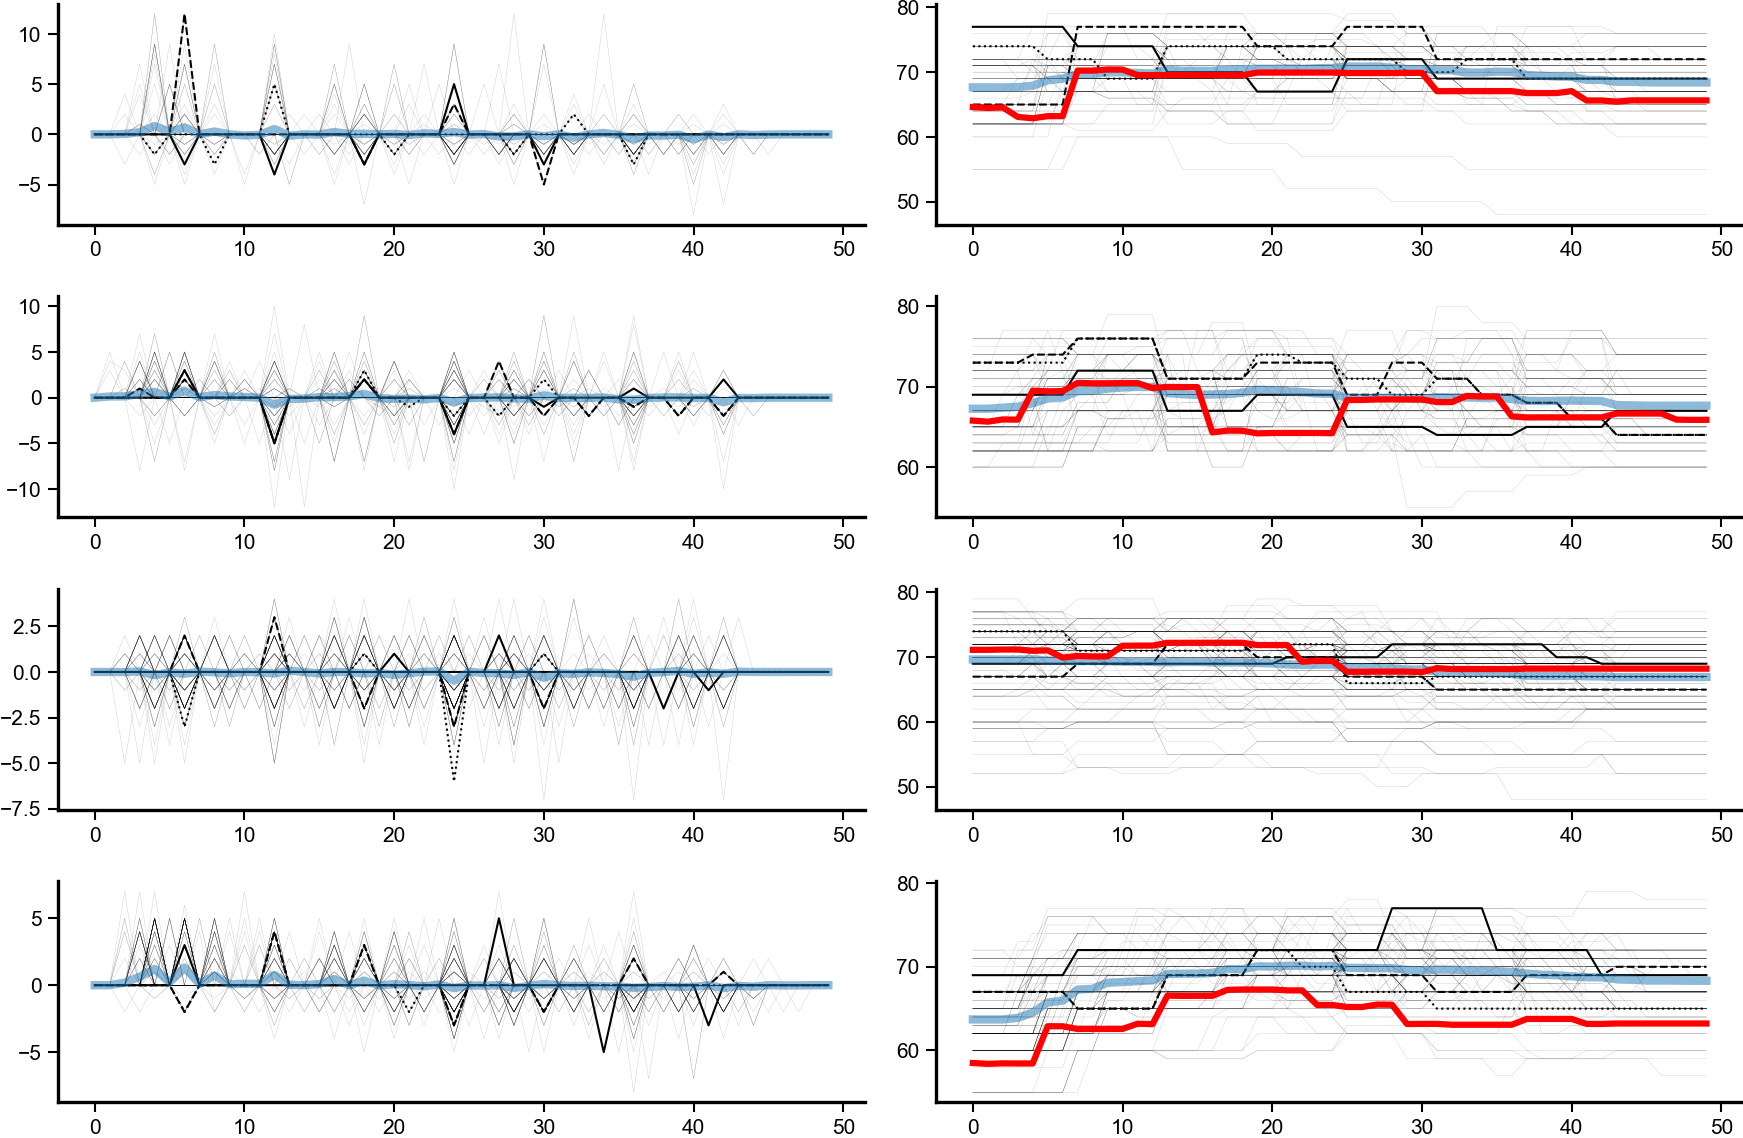

In [371]:
for cluster in range(4):
    plt.subplot(4, 2, 2*cluster + 1)
    show_contours(dataset[y_pred == cluster][:, :, 0])
    
    plt.subplot(4, 2, 2*cluster + 2)
    show_contours(contours['erk'][:500, :][y_pred == cluster, :]);
    center = integrate(km.cluster_centers_[[cluster],:,0])
    init_pitch = contours['erk'][:500, :][y_pred == cluster, :].mean(axis=0)[0]
    plt.plot(center.T - center.mean() + init_pitch, 'r');
    
plt.tight_layout()

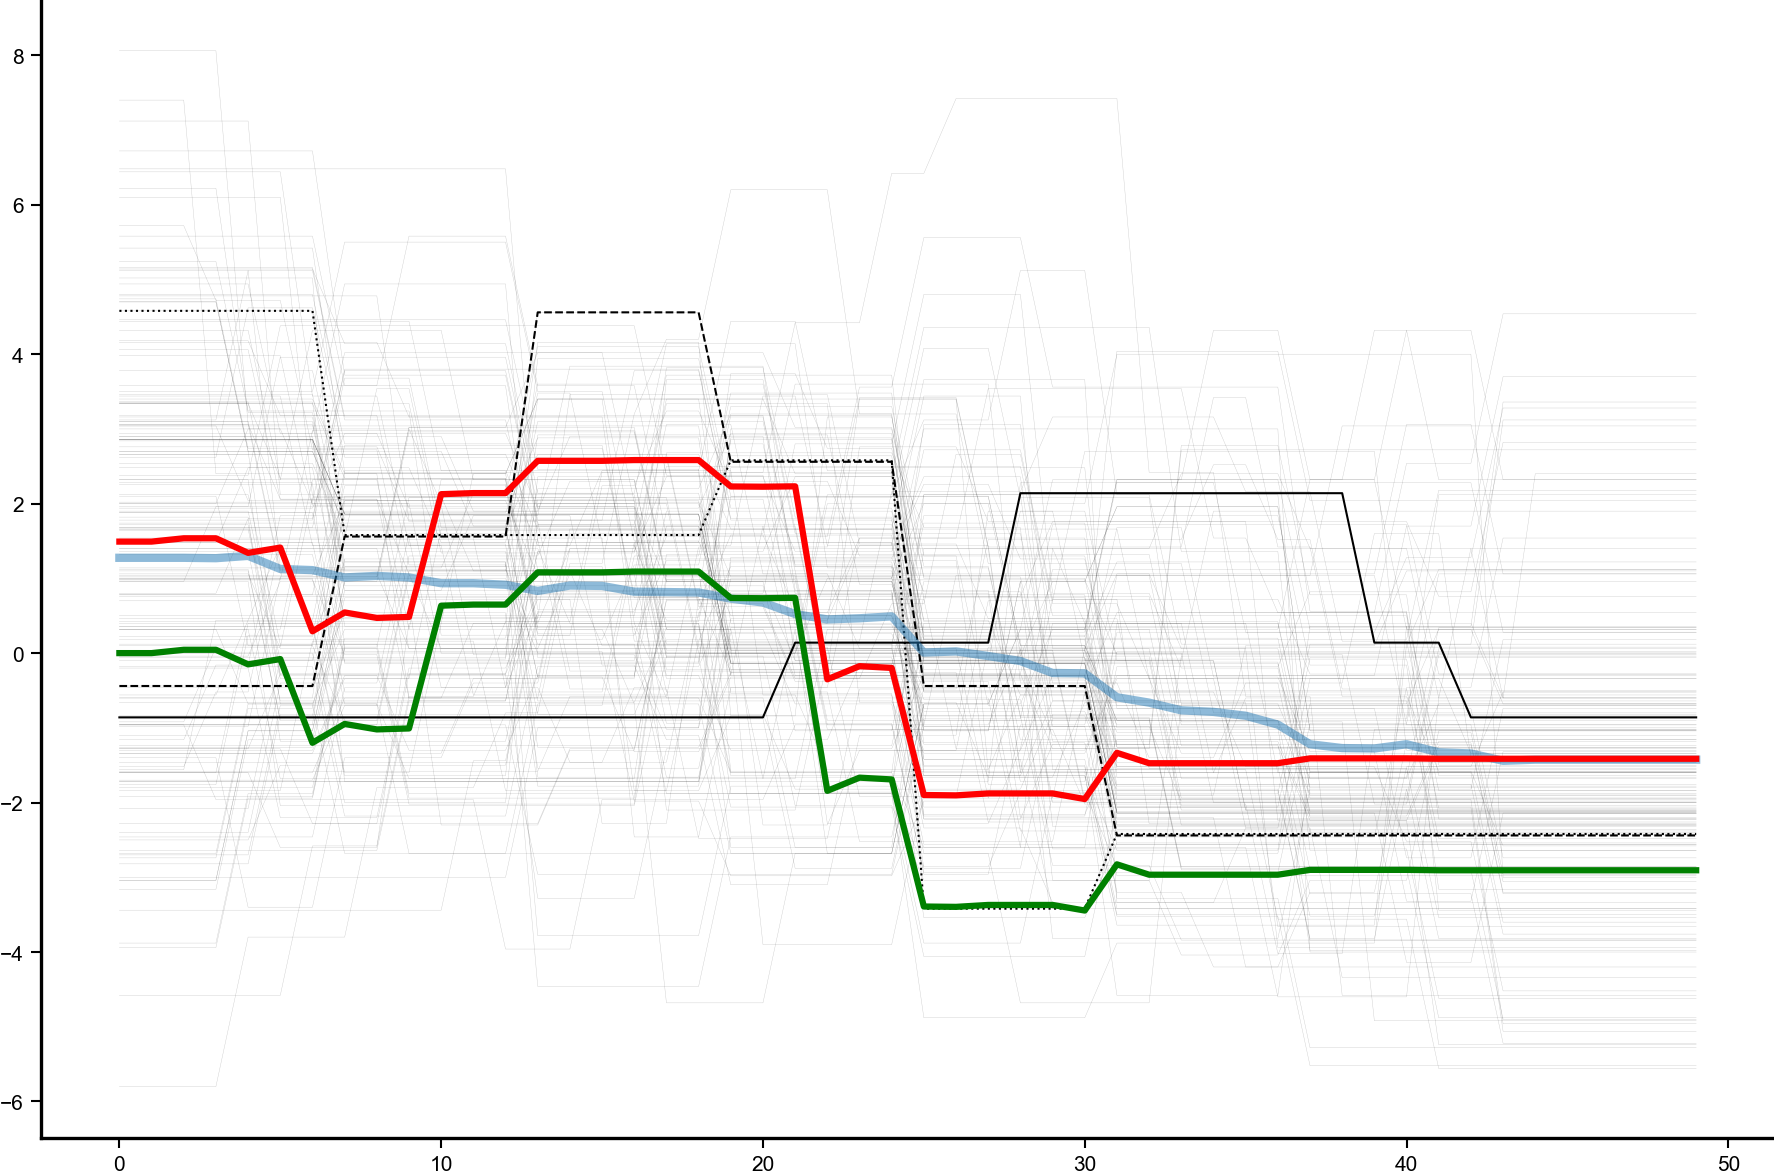

In [364]:
matches = dataset[y_pred == i][:, :, 0]
origs = integrate(matches)
origs = (origs - origs.mean(axis=1)[:, np.newaxis])
show_contours(origs)
# plt.plot(origs.T, 'k-', alpha=.1, lw=.1);
# # plt.plot(matches.mean(axis=0), 'r', lw=2)
center = integrate(km.cluster_centers_[[i],:,0])
plt.plot(center.T, 'g')
plt.plot(center.T - center.mean(), 'r');

## Other

In [337]:
# show_contours(contours['erk'][:500, :][y_pred == 1, :], normalize=False);

In [343]:
# show_contours(contours['erk'][:500, :][y_pred == 1, :], normalize=False);

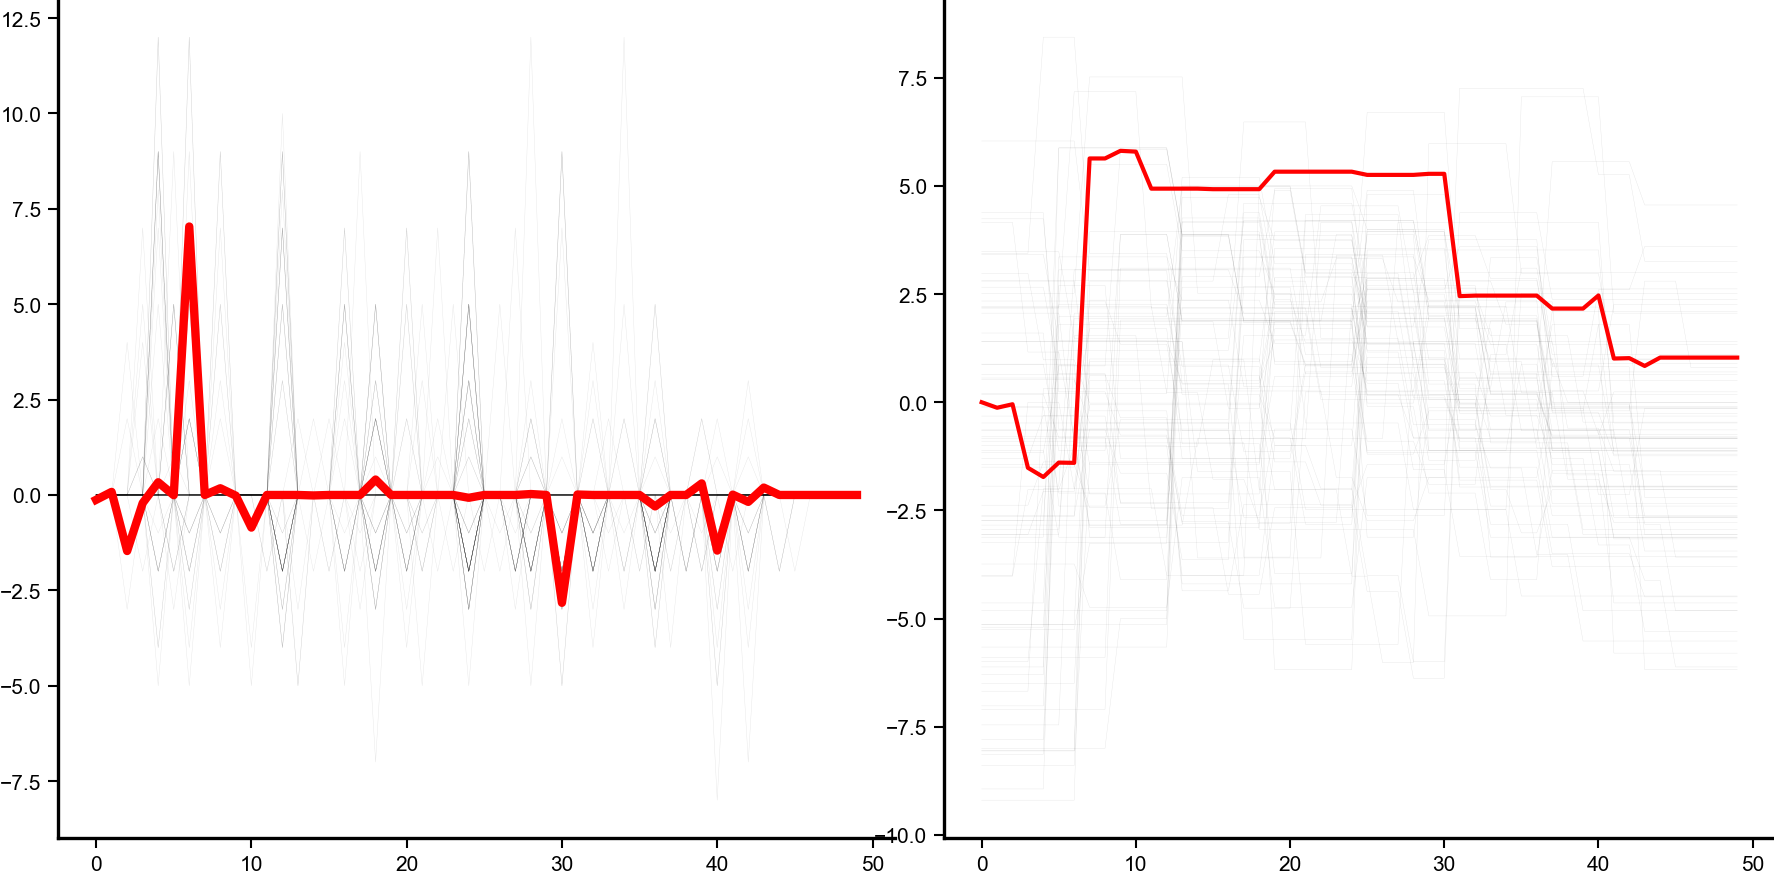

In [205]:
plt.figure(figsize=(6, 3))
i = 0

plt.subplot(121)
matches = dataset[y_pred == i][:, :, 0]
plt.plot(matches.T, 'k-', alpha=.1, lw=.1);
plt.plot(km.cluster_centers_[i,:,0], 'r', lw=2)

plt.subplot(122)
matches = dataset[y_pred == i][:, :, 0]
origs = integrate(matches)
origs = (origs - origs.mean(axis=1)[:, np.newaxis])
plt.plot(origs.T, 'k-', alpha=.1, lw=.1);
# plt.plot(matches.mean(axis=0), 'r', lw=2)
plt.plot(integrate(km.cluster_centers_[[i],:,0]).T, 'r', lw=1);

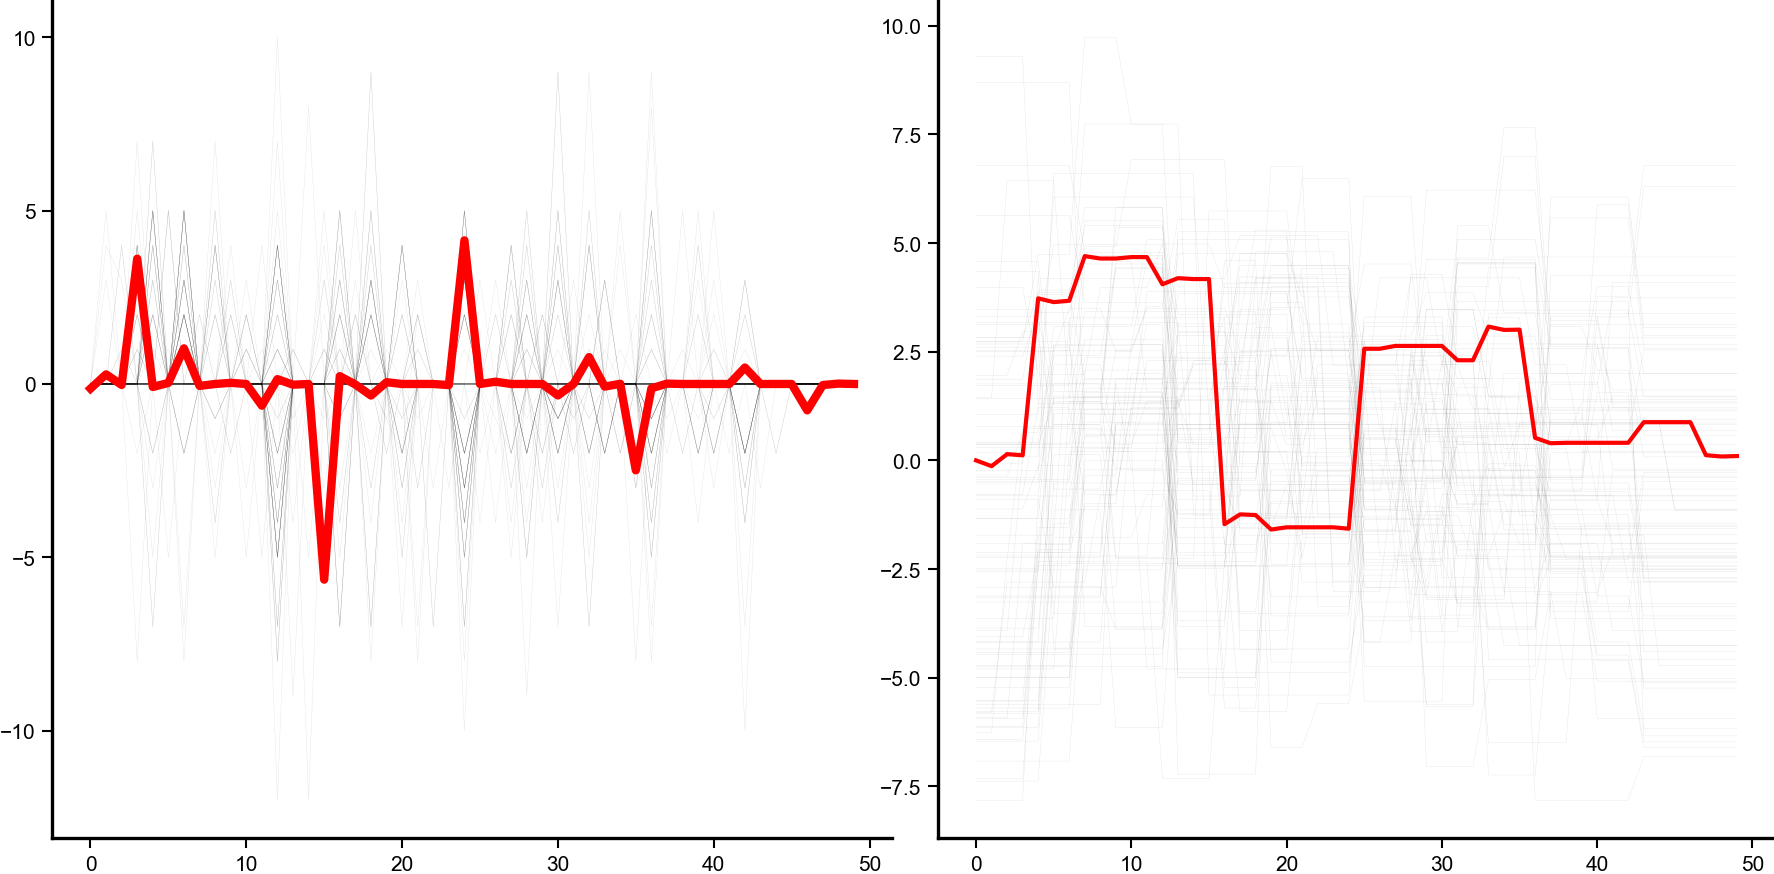

In [206]:
plt.figure(figsize=(6, 3))
i = 1

plt.subplot(121)
matches = dataset[y_pred == i][:, :, 0]
plt.plot(matches.T, 'k-', alpha=.1, lw=.1);
# plt.plot(matches.mean(axis=0), 'r', lw=2)
plt.plot(km.cluster_centers_[i,:,0], 'r', lw=2)

plt.subplot(122)
matches = dataset[y_pred == i][:, :, 0]
origs = integrate(matches)
origs = (origs - origs.mean(axis=1)[:, np.newaxis])
plt.plot(origs.T, 'k-', alpha=.1, lw=.1);
# plt.plot(matches.mean(axis=0), 'r', lw=2)
plt.plot(integrate(km.cluster_centers_[[i],:,0]).T, 'r', lw=1);

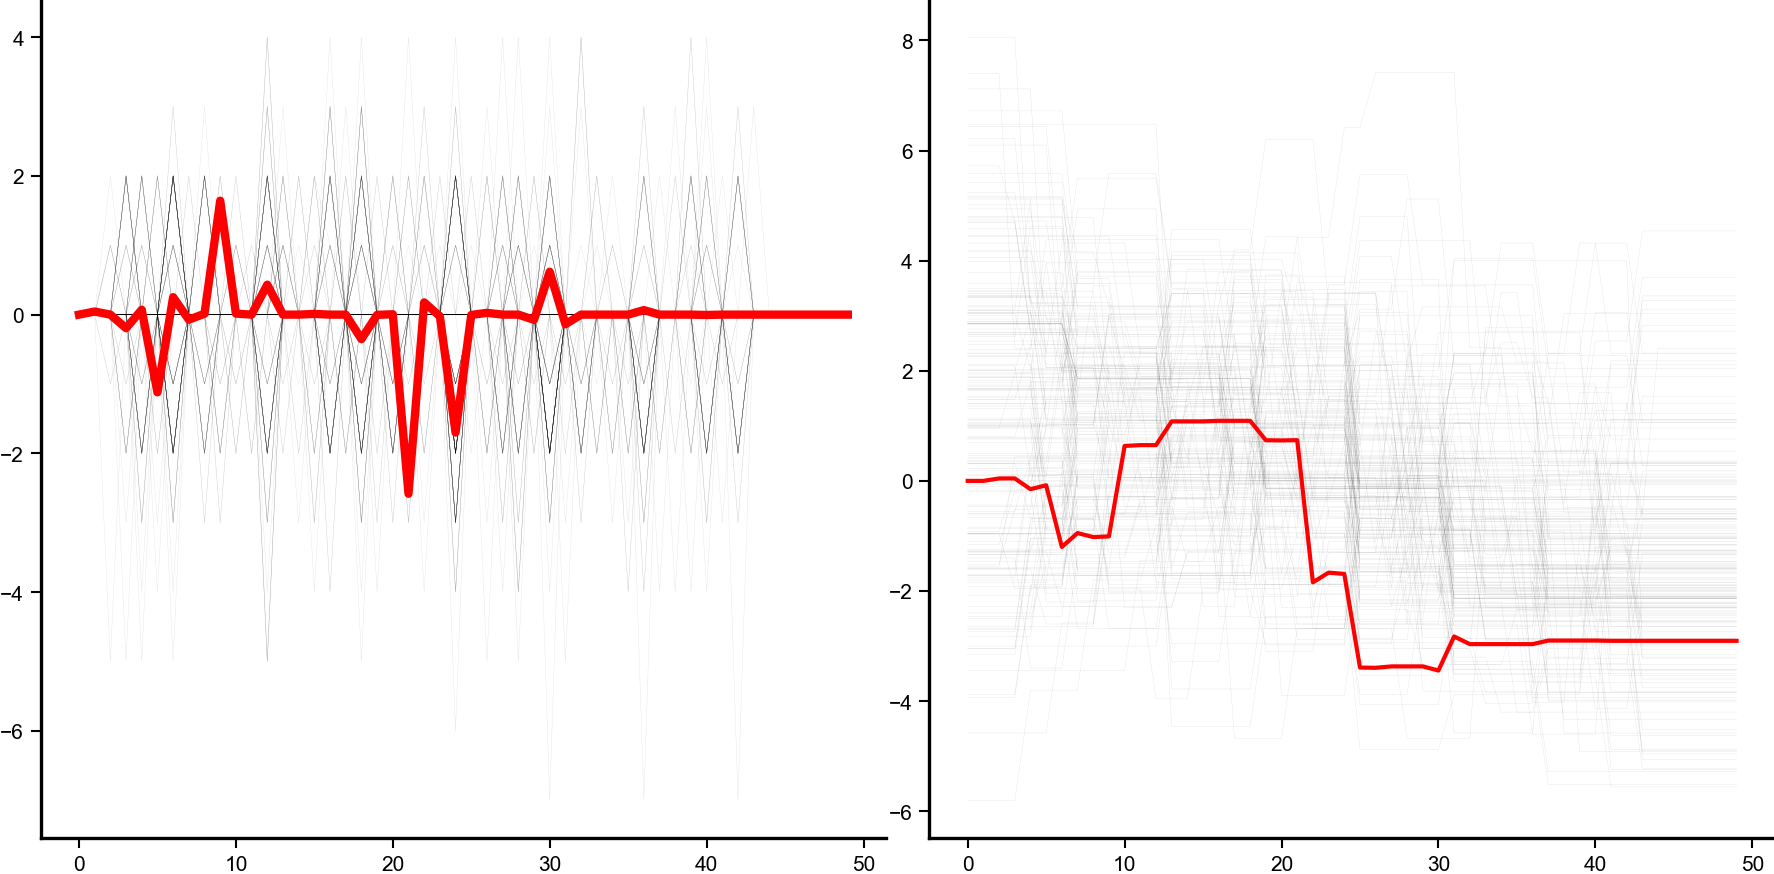

In [207]:
plt.figure(figsize=(6, 3))
i = 2

plt.subplot(121)
matches = dataset[y_pred == i][:, :, 0]
plt.plot(matches.T, 'k-', alpha=.1, lw=.1);
# plt.plot(matches.mean(axis=0), 'r', lw=2)
plt.plot(km.cluster_centers_[i,:,0], 'r', lw=2)

plt.subplot(122)
matches = dataset[y_pred == i][:, :, 0]
origs = integrate(matches)
origs = (origs - origs.mean(axis=1)[:, np.newaxis])
plt.plot(origs.T, 'k-', alpha=.1, lw=.1);
# plt.plot(matches.mean(axis=0), 'r', lw=2)
plt.plot(integrate(km.cluster_centers_[[i],:,0]).T, 'r', lw=1);

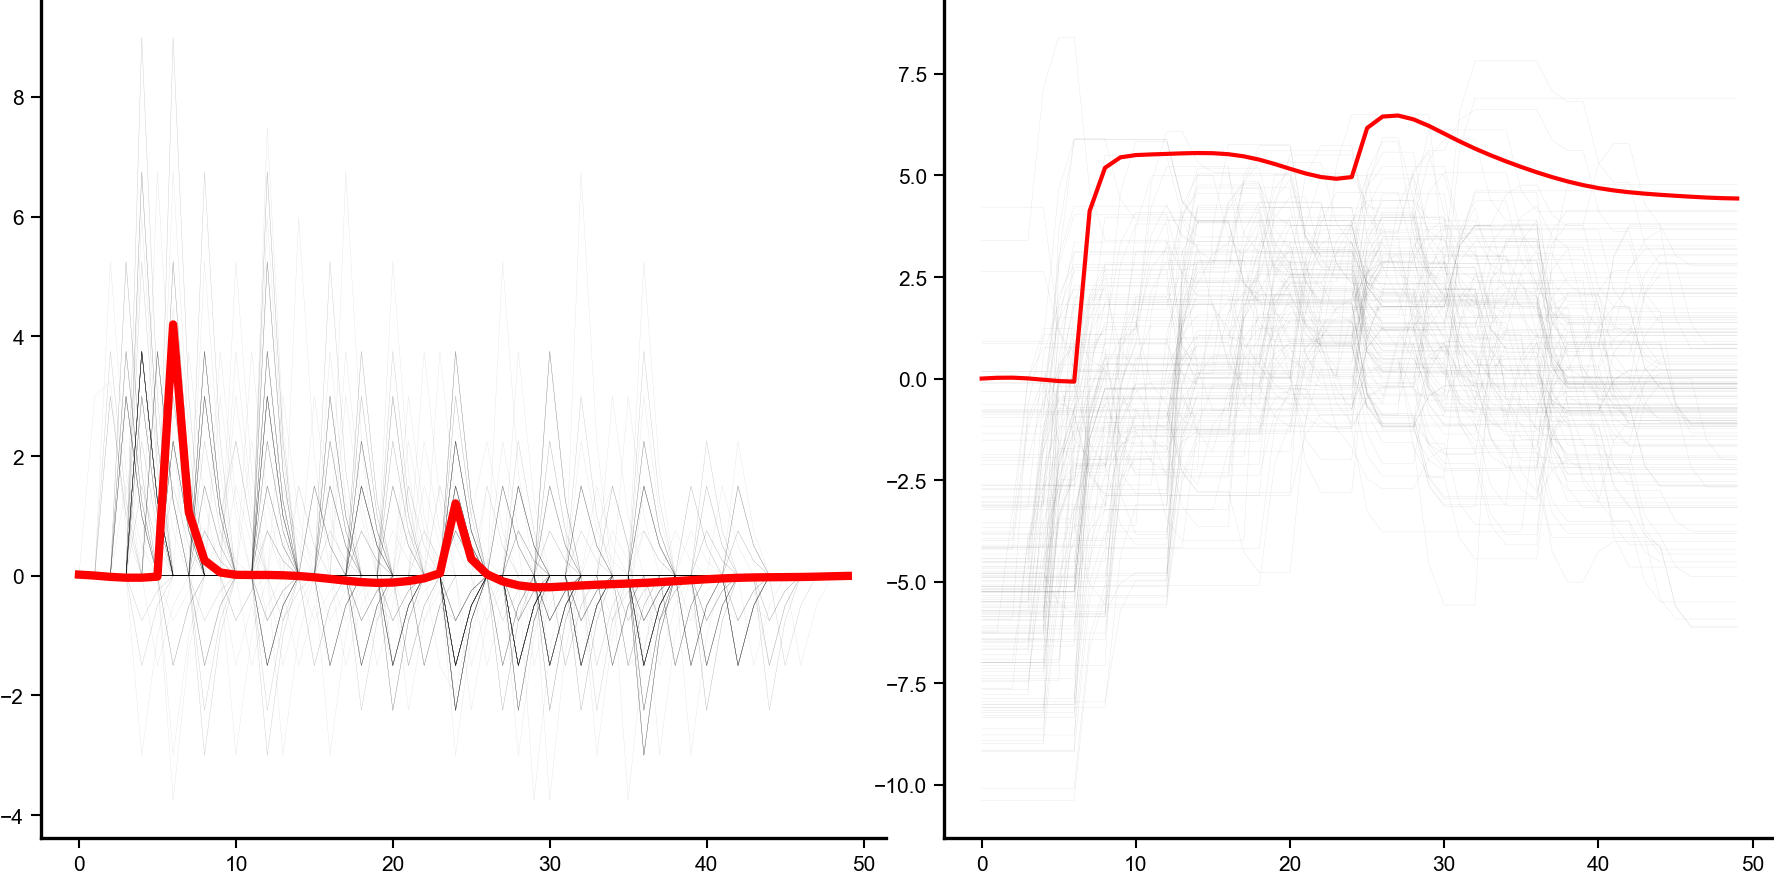

In [197]:
plt.figure(figsize=(6, 3))
i = 3

plt.subplot(121)
matches = dataset[y_pred == i][:, :, 0]
plt.plot(matches.T, 'k-', alpha=.1, lw=.1);
# plt.plot(matches.mean(axis=0), 'r', lw=2)
plt.plot(km.cluster_centers_[i,:,0], 'r', lw=2)

plt.subplot(122)
matches = dataset[y_pred == i][:, :, 0]
origs = integrate(matches)
origs = (origs - origs.mean(axis=1)[:, np.newaxis])
plt.plot(origs.T, 'k-', alpha=.1, lw=.1);
# plt.plot(matches.mean(axis=0), 'r', lw=2)
plt.plot(integrate(km.cluster_centers_[[i],:,0]).T, 'r', lw=1);

In [ ]:
plt.figure(figsize=(6, 6))
i = 0

plt.subplot(121)
matches = dataset[y_pred == i][:, :, 0]
plt.plot(matches.T, 'k-', alpha=.1, lw=.1);
# plt.plot(matches.mean(axis=0), 'r', lw=2)
plt.plot(km.cluster_centers_[i,:,0], 'r', lw=2)

plt.subplot(122)
matches = dataset[y_pred == i][:, :, 0]
origs = integrate(matches)
origs = (origs - origs.mean(axis=1)[:, np.newaxis])
plt.plot(origs.T, 'k-', alpha=.1, lw=.1);
# plt.plot(matches.mean(axis=0), 'r', lw=2)
plt.plot(integrate(km.cluster_centers_[[i],:,0]).T, 'r', lw=1);

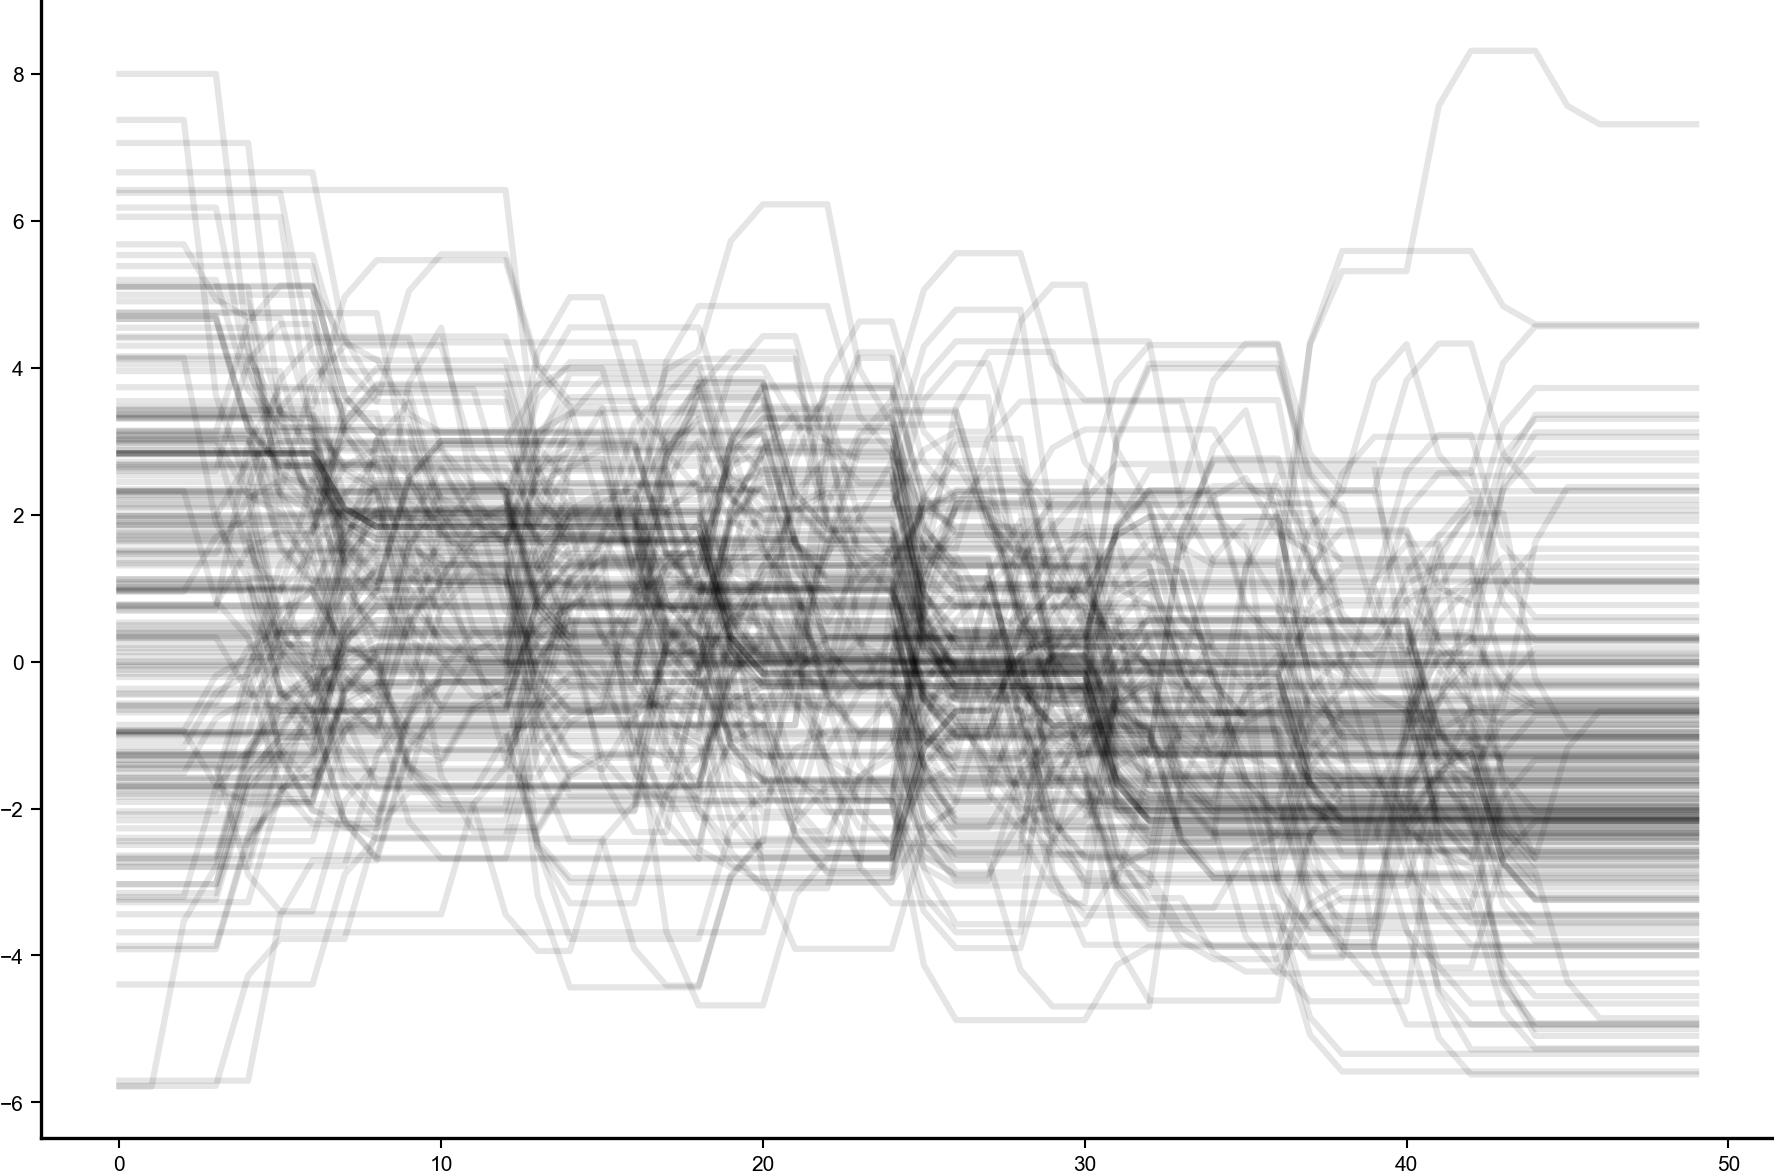

In [183]:
i = 0
matches = dataset[y_pred == i][:, :, 0]
origs = integrate(matches)
origs = (origs - origs.mean(axis=1)[:, np.newaxis])
plt.plot(origs.T, 'k-', alpha=.1);
# plt.plot(matches.mean(axis=0), 'r', lw=2)
plt.plot(integrate(km.cluster_centers_[[i],:,0]));

/Users/Bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doin

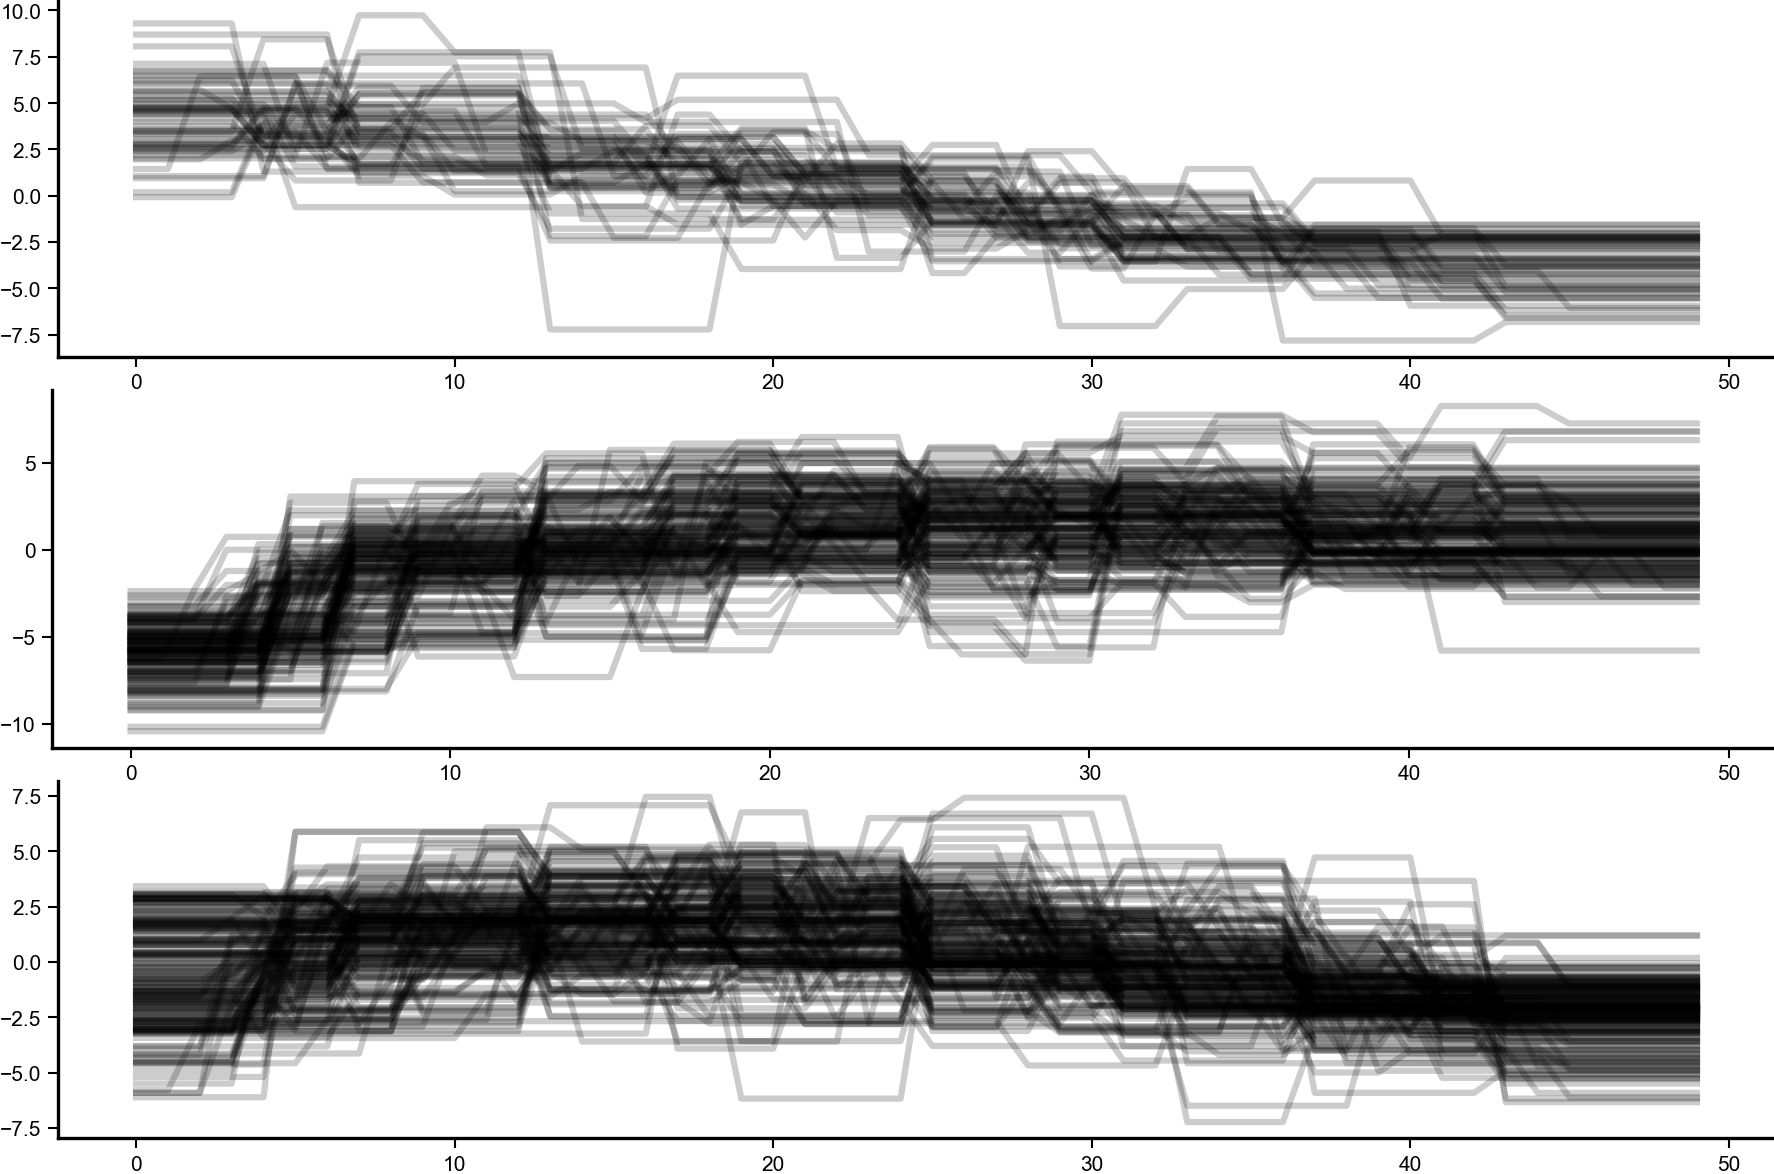

In [95]:
for yi in range(3):
    for xx in dataset[y_pred == yi]:
        plt.subplot(3, 1, yi+1)
        plt.plot(xx.ravel(), "k-", alpha=.2)

In [89]:
km.cluster_centers_.shape

(4, 50, 1)

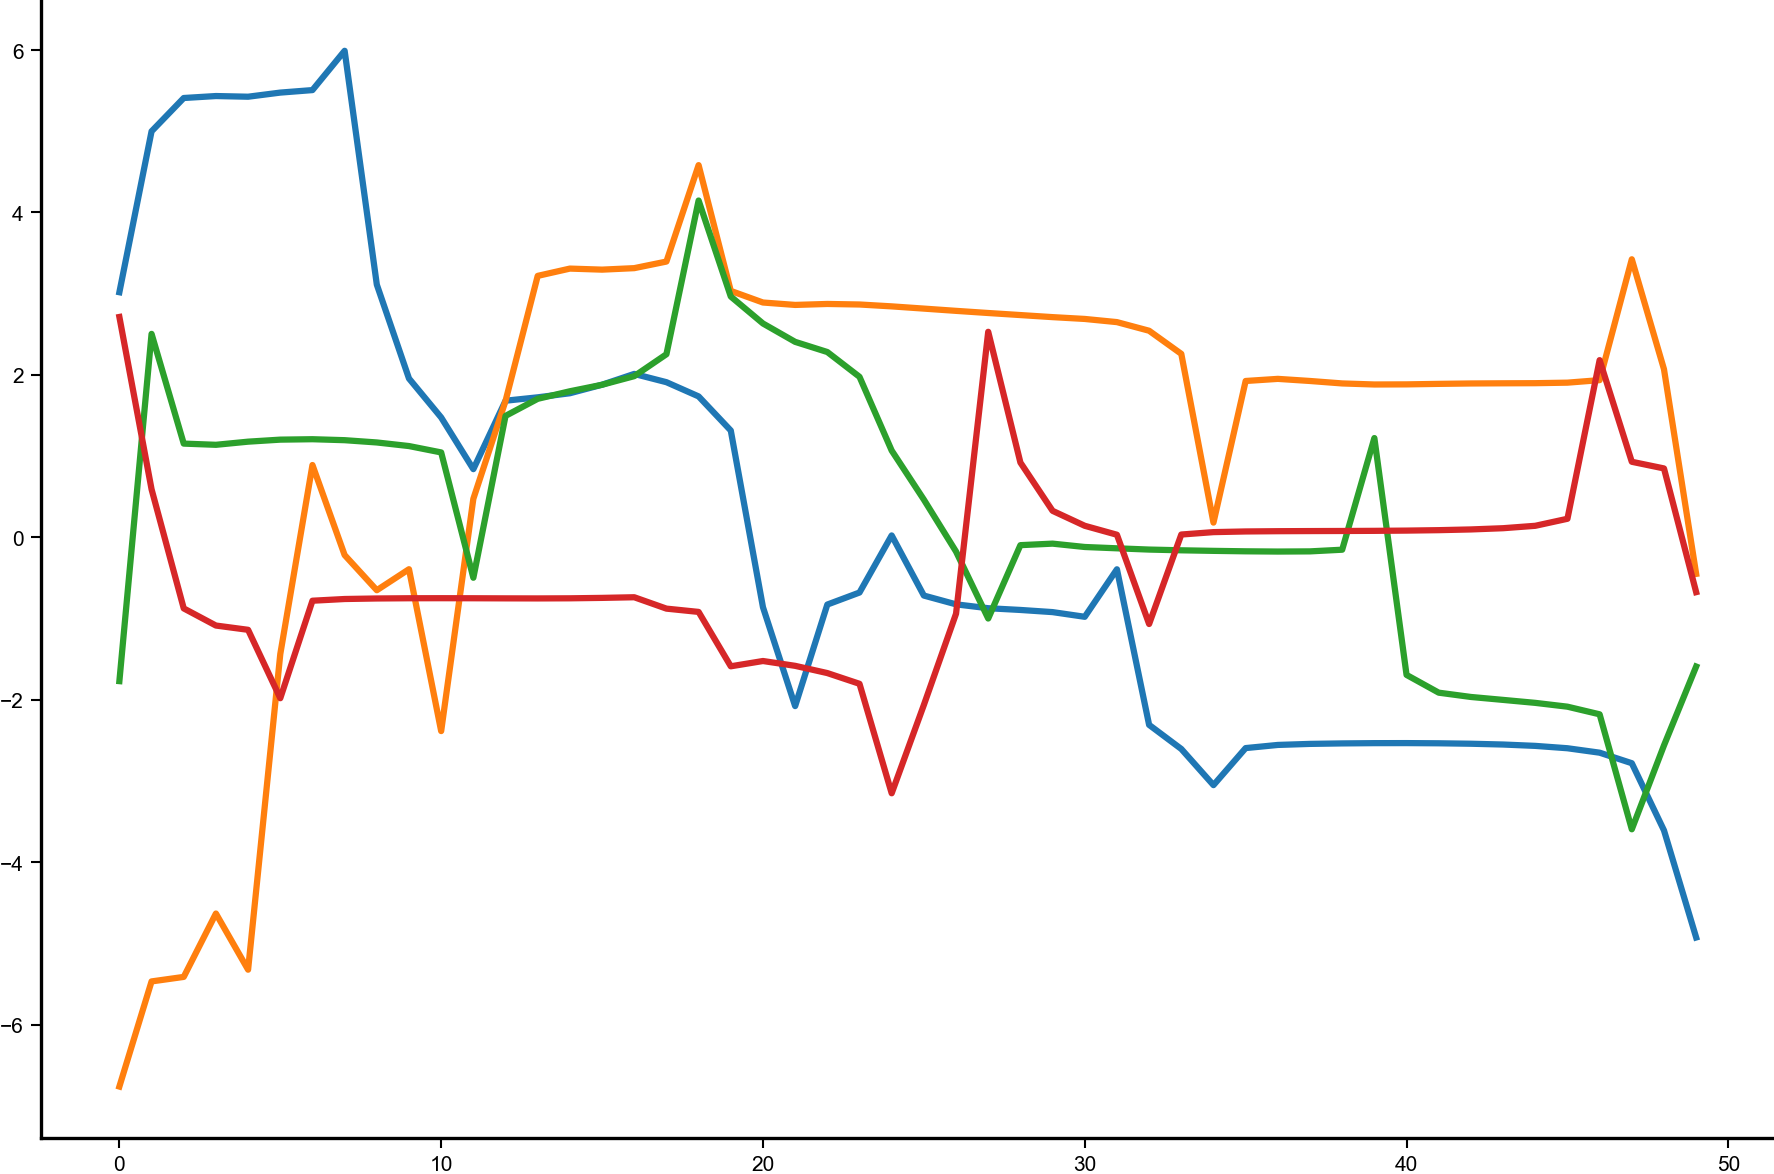

In [90]:
plt.plot(km.cluster_centers_[:, :, 0].T)

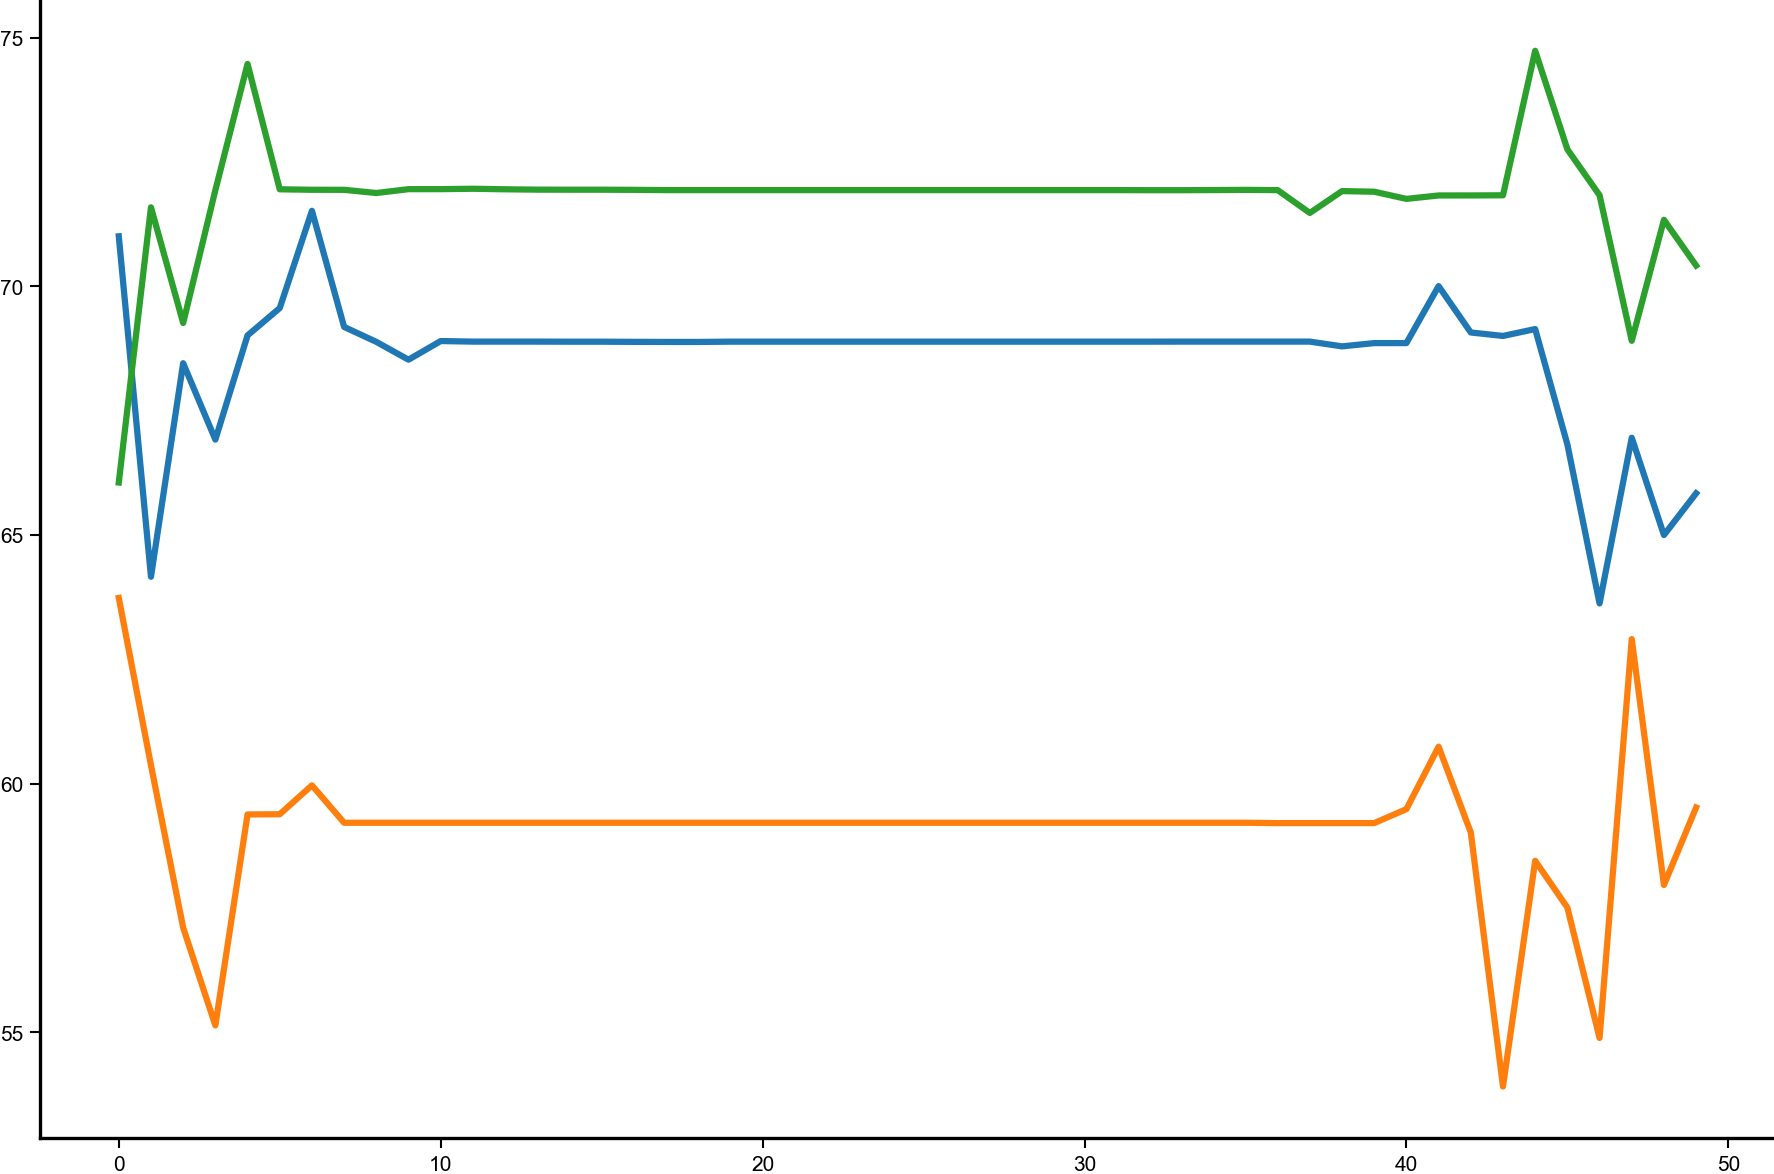

In [32]:
plt.plot(km.cluster_centers_[0])
plt.plot(km.cluster_centers_[1])
plt.plot(km.cluster_centers_[2])

In [6]:
a = [1, 3, 4, 2]
b = [1, 2, 4, 2]
dataset = to_time_series_dataset([a, b])

In [8]:
from tslearn.clustering import TimeSeriesKMeans
km = TimeSeriesKMeans(n_clusters=3, metric="dtw")
km.fit(X_train)

/Users/Bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


NameError: name 'X_train' is not defined